# Capacitively Coupled Circuit

This notebook computes the Hamiltonian of the directly coupled circuit. 

<center><img src="../images/circuit - direct coupling.png" width=600 height=600/></center>

We assume it can be reduced to the form

\begin{equation}
    \mathcal{H} = \frac{\Delta_p}{2} \sigma^{(p)}_z + 4 E_c (n^{(t)})^2 - E_J \cos(\phi^{(t)}) + g_\parallel \sigma^{(p)}_z n^{(t)} + g_\perp \sigma^{(p)}_x n^{(t)}
\end{equation}

## Install and Import Required Packages

In [1]:
%%capture out
!pip install matplotlib
!pip install scipy
!pip install tdqm
!pip install git+https://github.com/fmfn/BayesianOptimization
!pip install scikit-learn

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.sparse.linalg
import scipy.sparse as sparse
import json

from tqdm import tqdm

plt.style.use('science')

## Initialise Constants

In [2]:
h = 6.626e-34
hbar = 1.055e-34
e_charge = 1.60218e-19
flux_quanta = h / (2 * e_charge)

## Construct System Class

In [11]:
class SparseSystem:
    # EJ=121e9, CJ=8e-15, Cr=100e-15, Cc=5e-15, Lr=10e-9, alpha=0.4, ng=0.25
    def __init__(self, Ejp=153e9, Ejt=21.3e9, Cjp=12e-15, Cjt=36e-15, Cc=3.1e-15, Ct=18e-15, alpha=0.25, ng=0.12, flux=0.5, ncut=2):
        self.h = 6.626e-34
        self.hbar = 1.055e-34
        self.e_charge = -1.60218e-19
        
        self.Ejp = Ejp * self.h                 # Josephson energy of probe
        self.Ejt = Ejt * self.h                 # Josephson energy of target
        self.Cjp = Cjp                          # Josephson capacitance of probe
        self.Cjt = Cjt                          # Josephson capacitance of target
        self.Ct = Ct                            # Target Capacitor
        self.Cc = Cc                            # Coupling capacitance
        self.ng = ng                            # Reduced gate charge
        self.flux = flux                        # Flux through qubit
        self.ncut = ncut                        # Cut-off threshold for number basis
        self.alpha = alpha
        
        self.init_operators()
        
    def _print_params(self):
        print(f'Ejp:    {self.Ejp * 1e-9 / h} GHz')
        print(f'Ejt:    {self.Ejt * 1e-9 / h} GHz')
        print(f'Cjp:    {self.Cjp * 1e15} fF')
        print(f'Cjt:    {self.Cjt * 1e15} fF')
        print(f'Ct:    {self.Ct * 1e15} fF')
        print(f'Cc:    {self.Cc * 1e15} fF')
        print(f'alpha: {self.alpha}')
        print(f'ng:    {self.ng}')
        print(f'flux:  {self.flux}')

    def init_operators(self):
        self.I_cb = sp.sparse.diags(np.ones(2 * self.ncut + 1))   # Identity for qubit (charge basis)
        
        self.q_op_cb = sp.sparse.diags(2 * self.e_charge * np.arange(-self.ncut, self.ncut + 1, dtype=np.complex_))           # Charge operator (charge basis)
        self.ng_op_cb = 2 * self.e_charge * self.ng * self.I_cb
        self.e_iphi_op_cb = sp.sparse.diags(np.ones(2 * self.ncut, dtype=np.complex_), offsets=1)
        
        self.q1_q1_pt = self.tensor4(self.q_op_cb @ self.q_op_cb, self.I_cb, self.I_cb, self.I_cb)
        self.q1_q2_pt = self.tensor4(self.q_op_cb, self.q_op_cb, self.I_cb, self.I_cb)
        self.q1_q3_pt = self.tensor4(self.q_op_cb, self.I_cb, self.q_op_cb + self.ng_op_cb, self.I_cb)
        self.q1_q4_pt = self.tensor4(self.q_op_cb, self.I_cb, self.I_cb, self.q_op_cb)
        self.q2_q2_pt = self.tensor4(self.I_cb, self.q_op_cb @ self.q_op_cb, self.I_cb, self.I_cb)
        self.q2_q3_pt = self.tensor4(self.I_cb, self.q_op_cb, self.q_op_cb + self.ng_op_cb, self.I_cb)
        self.q2_q4_pt = self.tensor4(self.I_cb, self.q_op_cb, self.I_cb, self.q_op_cb)
        self.q3_q3_pt = self.tensor4(self.I_cb, self.I_cb, (self.q_op_cb + self.ng_op_cb) @ (self.q_op_cb + self.ng_op_cb), self.I_cb)
        self.q3_q4_pt = self.tensor4(self.I_cb, self.I_cb, self.q_op_cb + self.ng_op_cb, self.q_op_cb)
        self.q4_q4_pt = self.tensor4(self.I_cb, self.I_cb, self.I_cb, self.q_op_cb @ self.q_op_cb)
        
        self.q1_p = self.tensor3(self.q_op_cb, self.I_cb, self.I_cb)
        self.q2_p = self.tensor3(self.I_cb, self.q_op_cb, self.I_cb)
        self.q3_p = self.tensor3(self.I_cb, self.I_cb, self.q_op_cb + self.ng_op_cb)
        
        self.q1_q1_p = self.tensor3(self.q_op_cb @ self.q_op_cb, self.I_cb, self.I_cb)
        self.q1_q2_p = self.tensor3(self.q_op_cb, self.q_op_cb, self.I_cb)
        self.q1_q3_p = self.tensor3(self.q_op_cb, self.I_cb, self.q_op_cb + self.ng_op_cb)
        self.q2_q2_p = self.tensor3(self.I_cb, self.q_op_cb @ self.q_op_cb, self.I_cb)
        self.q2_q3_p = self.tensor3(self.I_cb, self.q_op_cb, self.q_op_cb + self.ng_op_cb)
        self.q3_q3_p = self.tensor3(self.I_cb, self.I_cb, (self.q_op_cb + self.ng_op_cb) @ (self.q_op_cb + self.ng_op_cb))
    
    def tensor3(self, op1, op2, op3):
        return sparse.kron(sparse.kron(op1, op2), op3)
    
    def tensor4(self, op1, op2, op3, op4):
        return sparse.kron(sparse.kron(sparse.kron(op1, op2), op3), op4)
    
    def hc(self, state):
        return np.conjugate(state).T

    def mod_squared(self, val):
        return np.real(val * np.conjugate(val))
        
    def get_kin_pt(self):
        self.init_operators()
        
        C_mat = [
            [(1 + self.alpha) * self.Cjp, 0, -self.alpha * self.Cjp, 0],
            [0, (1 + self.alpha) * self.Cjp, -self.alpha * self.Cjp, 0],
            [-self.alpha * self.Cjp, -self.alpha * self.Cjp, 2 * self.alpha * self.Cjp + self.Cc, -self.Cc],
            [0, 0, -self.Cc, self.Cjt + self.Cc + self.Ct]
        ]
        
        C_mat_in = np.linalg.inv(C_mat)

        kin_pt = C_mat_in[0][0] * self.q1_q1_pt
        kin_pt += C_mat_in[1][1] * self.q2_q2_pt
        kin_pt += C_mat_in[2][2] * self.q3_q3_pt
        kin_pt += C_mat_in[3][3] * self.q4_q4_pt
        kin_pt += 2 * C_mat_in[0][1] * self.q1_q2_pt
        kin_pt += 2 * C_mat_in[0][2] * self.q1_q3_pt
        kin_pt += 2 * C_mat_in[0][3] * self.q1_q4_pt
        kin_pt += 2 * C_mat_in[1][2] * self.q2_q3_pt
        kin_pt += 2 * C_mat_in[1][3] * self.q2_q4_pt
        kin_pt += 2 * C_mat_in[2][3] * self.q3_q4_pt
        
        kin_pt *= 0.5

        return kin_pt

    def get_pot_pt(self):
        self.init_operators()
        
        pot_pt = -self.Ejp * 0.5 * self.tensor4(self.e_iphi_op_cb + self.e_iphi_op_cb.T, self.I_cb, self.I_cb, self.I_cb)
        pot_pt += -self.Ejp * 0.5 * self.tensor4(self.I_cb, self.e_iphi_op_cb + self.e_iphi_op_cb.T, self.I_cb, self.I_cb)
        pot_pt += -self.Ejp * 0.5 * self.alpha * self.tensor4(self.e_iphi_op_cb.T, self.I_cb, self.e_iphi_op_cb, self.I_cb)
        pot_pt += -self.Ejp * 0.5 * self.alpha * self.tensor4(self.e_iphi_op_cb, self.I_cb, self.e_iphi_op_cb.T, self.I_cb)
        pot_pt += -self.Ejp * 0.5 * self.alpha * np.exp(2j * np.pi * self.flux) * self.tensor4(self.I_cb, self.e_iphi_op_cb, self.e_iphi_op_cb.T, self.I_cb)
        pot_pt += -self.Ejp * 0.5 * self.alpha * np.exp(-2j * np.pi * self.flux) * self.tensor4(self.I_cb, self.e_iphi_op_cb.T, self.e_iphi_op_cb, self.I_cb)
        pot_pt += self.Ejp * 2 * (1 + self.alpha) * self.tensor4(self.I_cb, self.I_cb, self.I_cb, self.I_cb)
        
        pot_pt += self.Ejt * self.tensor4(self.I_cb, self.I_cb, self.I_cb, self.I_cb)        
        pot_pt += -self.Ejt * self.tensor4(self.I_cb, self.I_cb, self.I_cb, self.e_iphi_op_cb + self.e_iphi_op_cb.T)
        
        return pot_pt
        
    def get_kin_p(self):
        self.init_operators()
        
        C_mat = [
            [(1 + self.alpha) * self.Cjp, 0, -self.alpha * self.Cjp],
            [0, (1 + self.alpha) * self.Cjp, -self.alpha * self.Cjp],
            [-self.alpha * self.Cjp, -self.alpha * self.Cjp, 2 * self.alpha * self.Cjp + self.Cc]
        ]
        
        C_mat_in = np.linalg.inv(C_mat)

        kin_p = C_mat_in[0][0] * self.q1_q1_p
        kin_p += C_mat_in[1][1] * self.q2_q2_p
        kin_p += C_mat_in[2][2] * self.q3_q3_p
        kin_p += 2 * C_mat_in[0][1] * self.q1_q2_p
        kin_p += 2 * C_mat_in[0][2] * self.q1_q3_p
        kin_p += 2 * C_mat_in[1][2] * self.q2_q3_p
        
        kin_p *= 0.5
        
        return kin_p

    def get_pot_p(self):
        self.init_operators()

        pot_p = -self.Ejp * 0.5 * self.tensor3(self.e_iphi_op_cb + self.e_iphi_op_cb.T, self.I_cb, self.I_cb)
        pot_p += -self.Ejp * 0.5 * self.alpha * self.tensor3(self.e_iphi_op_cb.T, self.I_cb, self.e_iphi_op_cb)
        pot_p += -self.Ejp * 0.5 * self.alpha * self.tensor3(self.e_iphi_op_cb, self.I_cb, self.e_iphi_op_cb.T)
        pot_p += -self.Ejp * 0.5 * self.alpha * np.exp(2j * np.pi * self.flux) * self.tensor3(self.I_cb, self.e_iphi_op_cb, self.e_iphi_op_cb.T)
        pot_p += -self.Ejp * 0.5 * self.alpha * np.exp(-2j * np.pi * self.flux) * self.tensor3(self.I_cb, self.e_iphi_op_cb.T, self.e_iphi_op_cb)
        pot_p += -self.Ejp * 0.5 * self.tensor3(self.I_cb, self.e_iphi_op_cb + self.e_iphi_op_cb.T, self.I_cb)
        pot_p += self.Ejp * 2 * (1 + self.alpha) * self.tensor3(self.I_cb, self.I_cb, self.I_cb)
        
        return pot_p
        
    def get_kin_t(self):
        self.init_operators()
        
        kin_t = 0.5 * (self.q_op_cb @ self.q_op_cb) / (self.Cjt + self.Ct + self.Cc)

        return kin_t

    def get_pot_t(self):
        self.init_operators()
        
        pot_t = self.Ejt * self.I_cb
        pot_t += -self.Ejt * (self.e_iphi_op_cb + self.e_iphi_op_cb.T)
        
        return pot_t

    def get_H_pt(self):
        self.H_pt = self.get_kin_pt() + self.get_pot_pt()
        self.H_pt.eliminate_zeros()
        
        return self.H_pt

    def get_H_p(self):
        self.H_p = self.get_kin_p() + self.get_pot_p()
        self.H_p.eliminate_zeros()
        
        return self.H_p

    def get_H_t(self):
        self.H_t = self.get_kin_t() + self.get_pot_t()
        
        return self.H_t
    
    def diagonalise_pt(self, update=False):
        if update:
            self.get_H_pt()
        else:
            try:
                self.H_pt
            except AttributeError:
                self.get_H_pt()
        
        self.evals_pt, evecs = sparse.linalg.eigs(
            self.H_pt, k=10, which='SR'
        )
        
        evecs = evecs.T
        self.evecs_pt = [
            sp.sparse.csr_array(evecs[0]),
            sp.sparse.csr_array(evecs[1]),
        ]
        
        return self.evals_pt, self.evecs_pt
    
    def diagonalise_p(self, update=False):
        if update:
            self.get_H_p()
        else:
            try:
                self.H_p
            except AttributeError:
                self.get_H_p()
        
        self.evals_p, evecs = sparse.linalg.eigs(
            self.H_p, k=10, which='SR'
        )
        
        evecs = evecs.T
        self.evecs_p = [
            sp.sparse.csr_array(evecs[0]),
            sp.sparse.csr_array(evecs[1]),
        ]
        
        return self.evals_p, self.evecs_p
    
    def diagonalise_t(self, update=False):
        if update:
            self.get_H_t()
        else:
            try:
                self.H_t
            except AttributeError:
                self.get_H_t()
        
        self.evals_t, evecs = sparse.linalg.eigs(
            self.H_t, k=2, which='SR'
        )
        
        evecs = evecs.T
        self.evecs_t = [
            sp.sparse.csr_array(evecs[0]),
            sp.sparse.csr_array(evecs[1]),
        ]
        
        return self.evals_t, self.evecs_t
    
    def init_qubit_states(self, update=False):
        if update:
            self.diagonalise_p(update=True)
            self.diagonalise_t(update=True)
        else:
            try:
                self.evecs_p
                self.evecs_t
            except AttributeError:
                self.diagonalise_p()
                self.diagonalise_t()

        self.probe_0_eb = self.evecs_p[0].T
        self.probe_1_eb = self.evecs_p[1].T
        self.probe_p_eb = 2**-0.5 * (self.probe_0_eb + self.probe_1_eb)
        self.probe_m_eb = 2**-0.5 * (self.probe_0_eb - self.probe_1_eb)
        self.probe_ip_eb = 2**-0.5 * (self.probe_0_eb + 1j * self.probe_1_eb)
        self.probe_im_eb = 2**-0.5 * (self.probe_0_eb - 1j * self.probe_1_eb)

        self.target_0_eb = self.evecs_t[0].T
        self.target_1_eb = self.evecs_t[1].T
        self.target_m_eb = 2**-0.5 * (self.target_0_eb - self.target_1_eb)
        self.target_p_eb = 2**-0.5 * (self.target_0_eb + self.target_1_eb)
        
        self.target_0_cb = sp.sparse.csr_matrix((2 * self.ncut + 1,1))
        self.target_0_cb[self.ncut,0] = 1
        self.target_1_cb = sp.sparse.csr_matrix((2 * self.ncut + 1,1))
        self.target_1_cb[self.ncut + 1,0] = 1

    def init_prod_states(self, update=False):
        if update:
            self.init_qubit_states(update=True)
        else:
            try:
                self.probe_0
            except AttributeError:
                self.init_qubit_states()

        self.eb_eb_00 = sp.sparse.kron(self.probe_0_eb, self.target_0_eb)
        self.eb_eb_01 = sp.sparse.kron(self.probe_0_eb, self.target_1_eb)
        self.eb_eb_10 = sp.sparse.kron(self.probe_1_eb, self.target_0_eb)
        self.eb_eb_11 = sp.sparse.kron(self.probe_1_eb, self.target_1_eb)

        self.eb_cb_00 = sp.sparse.kron(self.probe_0_eb, self.target_0_cb)
        self.eb_cb_01 = sp.sparse.kron(self.probe_0_eb, self.target_1_cb)
        self.eb_cb_10 = sp.sparse.kron(self.probe_1_eb, self.target_0_cb)
        self.eb_cb_11 = sp.sparse.kron(self.probe_1_eb, self.target_1_cb)
        self.eb_cb_p0 = sp.sparse.kron(self.probe_p_eb, self.target_0_cb)
        self.eb_cb_p1 = sp.sparse.kron(self.probe_p_eb, self.target_1_cb)
        self.eb_cb_m0 = sp.sparse.kron(self.probe_m_eb, self.target_0_cb)
        self.eb_cb_m1 = sp.sparse.kron(self.probe_m_eb, self.target_1_cb)
    
    def calc_delta_p(self, update=False):
        if update:
            self.get_H_pt()
            self.init_prod_states(update=True)
        else:
            try:
                self.H_pt
            except AttributeError:
                self.get_H_pt()

            try:
                self.ket_p1
            except AttributeError:
                self.init_prod_states()

        delta_p = (self.hc(self.eb_eb_10).dot(self.H_pt.dot(self.eb_eb_10)) - self.hc(self.eb_eb_00).dot(self.H_pt.dot(self.eb_eb_00))).toarray()[0][0]
        
        return delta_p
    
    def calc_delta_t(self, update=False):
        if update:
            self.get_H_pt()
            self.init_prod_states(update=True)
        else:
            try:
                self.H_pt
            except AttributeError:
                self.get_H_pt()

            try:
                self.ket_p1
            except AttributeError:
                self.init_prod_states()

        delta_t = (self.hc(self.eb_eb_01).dot(self.H_pt.dot(self.eb_eb_01)) - self.hc(self.eb_eb_00).dot(self.H_pt.dot(self.eb_eb_00))).toarray()[0][0]

        return delta_t
    
    def calc_g_parr(self, update=False):
        if update:
            self.get_H_pt()
            self.init_prod_states(update=True)
        else:
            try:
                self.H_pt
            except AttributeError:
                self.get_H_pt()

            try:
                self.eb_cb_p1
            except AttributeError:
                self.init_prod_states()
        
        g_parr = self.hc(self.eb_cb_p1).dot(self.H_pt.dot(self.eb_cb_m1)).toarray()[0][0] - self.hc(self.eb_cb_p0).dot(self.H_pt.dot(self.eb_cb_m0)).toarray()[0][0]
        
        return g_parr
    
    def calc_g_perp(self, update=False):
        if update:
            self.get_H_pt()
            self.init_prod_states(update=True)
        else:
            try:
                self.H_pt
            except AttributeError:
                self.get_H_pt()

            try:
                self.eb_cb_11
            except AttributeError:
                self.init_prod_states()
        
        g_perp = self.hc(self.eb_cb_11).dot(self.H_pt.dot(self.eb_cb_01)).toarray()[0][0] - self.hc(self.eb_cb_10).dot(self.H_pt.dot(self.eb_cb_00)).toarray()[0][0]
        
        return g_perp
    
    def calc_D(self, ng0=0.5, diff_param=0.01):
        self.ng=0
        self.init_qubit_states(update=True)
        H_p = self.get_H_p()

        state_p = self.probe_p_eb.copy()
        state_ip = self.probe_ip_eb.copy()
        state_1 = self.probe_1_eb.copy()

        H_x = self.hc(state_p).dot(H_p.dot(state_p)).toarray()[0][0]
        H_y = self.hc(state_ip).dot(H_p.dot(state_ip)).toarray()[0][0]
        H_z = self.hc(state_1).dot(H_p.dot(state_1)).toarray()[0][0]

        self.omega_01 = np.sqrt(self.mod_squared(H_x) + self.mod_squared(H_y) + self.mod_squared(H_z))

        sys.ng = ng0 + 0.5 * diff_param
        evals_high, _ = self.diagonalise_p(update=True)
        omega01_high = (evals_high[1] - evals_high[0]) / self.hbar

        sys.ng = ng0 - 0.5 * diff_param
        evals_low, _ = self.diagonalise_p(update=True)
        omega01_low = (evals_low[1] - evals_low[0]) / self.hbar
        
        self.D_omega01 = (omega01_high - omega01_low) / diff_param

        sys.ng = ng0 + 0.5 * diff_param
        H_p = self.get_H_p()
        H_z_high = self.hc(sys.probe_1_eb).dot(H_p.dot(self.probe_1_eb)).toarray()[0][0]

        sys.ng = ng0 - 0.5 * diff_param
        H_p = self.get_H_p()
        H_z_low = self.hc(self.probe_1_eb).dot(H_p.dot(self.probe_1_eb)).toarray()[0][0]

        self.D_z = np.sqrt(self.mod_squared((H_z_high - H_z_low) / diff_param)) / self.h

        sys.ng = ng0
        H_p = self.get_H_p()
        H_z = self.hc(self.probe_1_eb).dot(H_p.dot(self.probe_1_eb)).toarray()[0][0]

        sys.ng = ng0 + diff_param
        H_p = self.get_H_p()
        H_z_high = self.hc(self.probe_1_eb).dot(H_p.dot(self.probe_1_eb)).toarray()[0][0]

        sys.ng = ng0 - diff_param
        H_p = self.get_H_p()
        H_z_low = self.hc(self.probe_1_eb).dot(H_p.dot(self.probe_1_eb)).toarray()[0][0]

        self.D2_z = np.sqrt(self.mod_squared((H_z_high - 2 * H_z + H_z_low) / diff_param**2)) / self.h**2

        sys.ng = ng0 + 0.5 * diff_param
        H_p = sys.get_H_p()
        H_x_high = self.hc(self.probe_p_eb).dot(H_p.dot(self.probe_p_eb)).toarray()[0][0]
        H_y_high = self.hc(self.probe_ip_eb).dot(H_p.dot(self.probe_ip_eb)).toarray()[0][0]

        sys.ng = ng0 - 0.5 * diff_param
        H_p = sys.get_H_p()
        H_x_low = self.hc(self.probe_p_eb).dot(H_p.dot(self.probe_p_eb)).toarray()[0][0]
        H_y_low = self.hc(self.probe_ip_eb).dot(H_p.dot(self.probe_ip_eb)).toarray()[0][0]

        self.D_perp = np.sqrt(self.mod_squared((H_x_high - H_x_low) / diff_param) + self.mod_squared((H_y_high - H_y_low) / diff_param)) / self.h


## Visualise Hamiltonians

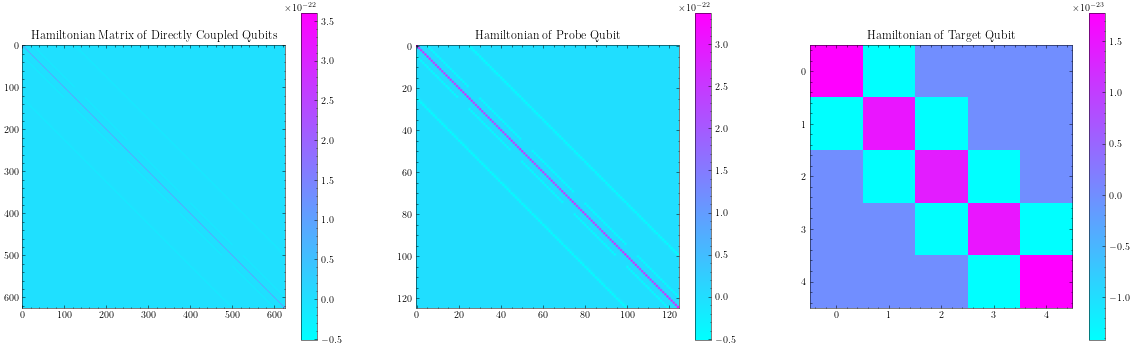

In [5]:
system = SparseSystem(ncut=2)

H_pt = system.get_H_pt()
H_p = system.get_H_p()
H_t = system.get_H_t()

if type(H_pt) == scipy.sparse.csr_matrix:
    H_pt = H_pt.toarray()
    H_p = H_p.toarray()
    H_t = H_t.toarray()

f = plt.figure(figsize=(20,6))

ax1 = f.add_subplot(131)
ax1.title.set_text('Hamiltonian Matrix of Directly Coupled Qubits')
im1 = ax1.imshow(np.real(H_pt), cmap=plt.get_cmap('cool'))
f.colorbar(im1)

ax2 = f.add_subplot(132)
ax2.title.set_text('Hamiltonian of Probe Qubit')
im2 = ax2.imshow(np.real(H_p), cmap=plt.get_cmap('cool'))
f.colorbar(im2)

ax3 = f.add_subplot(133)
ax3.title.set_text('Hamiltonian of Target Qubit')
im3 = ax3.imshow(np.real(H_t), cmap=plt.get_cmap('cool'))
f.colorbar(im3)

plt.show()

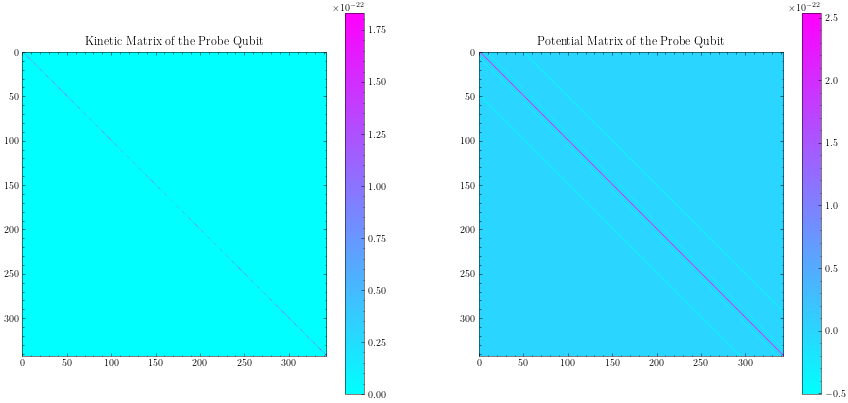

In [6]:
system = SparseSystem(ncut=3)

kin_p = system.get_kin_p()
pot_p = system.get_pot_p()

if type(kin_p) == scipy.sparse.csr_matrix:
    kin_p = kin_p.toarray()
    pot_p = pot_p.toarray()

f = plt.figure(figsize=(15,7))

ax1 = f.add_subplot(121)
ax1.title.set_text('Kinetic Matrix of the Probe Qubit')
im1 = ax1.imshow(np.real(kin_p), cmap=plt.get_cmap('cool'))
f.colorbar(im1)

ax2 = f.add_subplot(122)
ax2.title.set_text('Potential Matrix of the Probe Qubit')
im2 = ax2.imshow(np.real(pot_p), cmap=plt.get_cmap('cool'))
f.colorbar(im2)
plt.show()

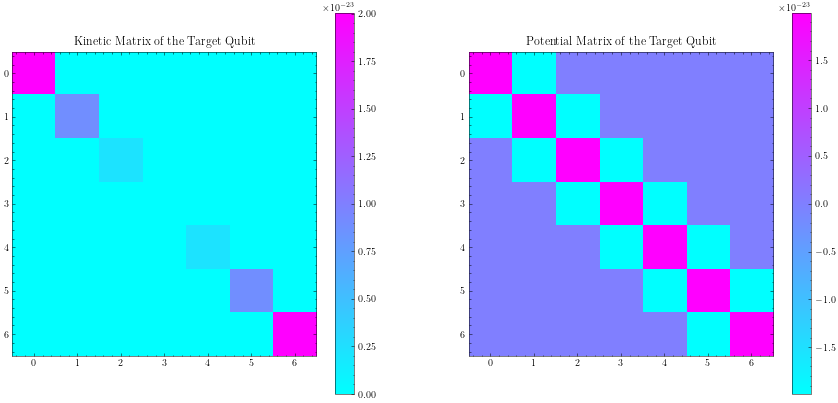

In [7]:
system = SparseSystem(ncut=3, Cjt=1e-14, Ct=1e-14, Ejt=30e9)

kin_t = system.get_kin_t()
pot_t = system.get_pot_t()

if type(kin_t) == scipy.sparse.csr_matrix:
    kin_t = kin_t.toarray()
    pot_t = pot_t.toarray()

f = plt.figure(figsize=(15,7))

ax1 = f.add_subplot(121)
ax1.title.set_text('Kinetic Matrix of the Target Qubit')
im1 = ax1.imshow(np.real(kin_t), cmap=plt.get_cmap('cool'))
f.colorbar(im1)

ax2 = f.add_subplot(122)
ax2.title.set_text('Potential Matrix of the Target Qubit')
im2 = ax2.imshow(np.real(pot_t), cmap=plt.get_cmap('cool'))
f.colorbar(im2)
plt.show()

# Determine Approximate Hamiltonian Parameters

We assume that the Hamiltonian can be approximated by

\begin{equation}
    \mathcal{H} = \frac{\Delta_p}{2} \sigma^{(p)}_z + \frac{\Delta_t}{2} \sigma^{(t)}_z + i g_\parallel \sigma^{(p)}_z  n^{(t)} + i g_\perp \sigma^{(p)}_x n^{(t)}
\end{equation}

In [8]:
sys = SparseSystem(ncut=5)

delta_p = sys.calc_delta_p()
delta_t = sys.calc_delta_t()
g_parr = sys.calc_g_parr()
g_perp = sys.calc_g_perp()

print(f'∆_p: {np.real(delta_p) * 1e-9 / h} GHz')
print(f'∆_t: {np.real(delta_t) * 1e-9 / h} GHz')
print(f'g_parr: {np.real(g_parr)}')
print(f'g_perp: {np.real(g_perp)}')

∆_p: 5.016779475053899 GHz
∆_t: 10.56232870783248 GHz
g_parr: 1.5991586396946703e-25
g_perp: 8.658202738783617e-39


/home/daniel/.local/lib/python3.8/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


## Figure 17a

In [9]:
system = SparseSystem(ncut=6, Cc=6.76e-15, Cjp=4.767e-16, Cjt=1.683e-14, Ct=1.705e-14, Ejp=2.86e+11, Ejt=4.851e+10, alpha=0.2829)
fig17a_ngs = np.linspace(-1, 1, 100)
alphas = np.linspace(0.17, 0.6, 2)
# alphas = np.linspace(0.17, 0.6, 8)
fig17a_data_p, fig17a_data_t = {}, {}

system._print_params()

for alpha in alphas:
    system.alpha = alpha
    fig17a_data_p[alpha] = []
    fig17a_data_t[alpha] = []
    for ng in tqdm(fig17a_ngs):
        system.ng = ng

        # Full Hamiltonina Approach
        delta_p = system.calc_delta_p(update=True)
        delta_t = system.calc_delta_t()
        
        fig17a_data_p[alpha].append(delta_p)
        fig17a_data_t[alpha].append(delta_t)

Ejp:    286.0 GHz
Ejt:    48.51 GHz
Cjp:    0.4767 fF
Cjt:    16.83 fF
Ct:    17.05 fF
Cc:    6.76 fF
alpha: 0.2829
ng:    0.12
flux:  0.5


100%|█████████████████████████████████████████| 100/100 [01:26<00:00,  1.16it/s]


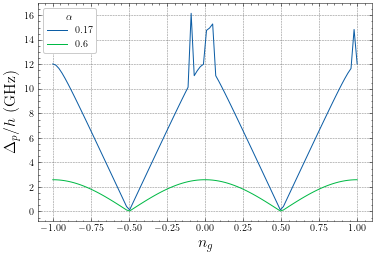

In [17]:
pparam = dict(xlabel='$n_g$', ylabel='$\Delta_p / h$ (GHz)')

with plt.style.context(['science', 'grid']):
    fig, ax = plt.subplots(figsize=(6,4))
    for alpha in fig17a_data_p.keys():
        ax.plot(fig17a_ngs, [np.abs(delta) * 1e-9 / h for delta in fig17a_data_p[alpha]], label=round(alpha,2))
    ax.legend(title='$\\alpha$')
    ax.set(**pparam)
    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)
    fig.savefig('figures/Direct Coupling/Delta wrt alpha ng optimal.png', dpi=300)
    plt.show()

## Figure 17b

In [18]:
system = SparseSystem(ncut=5, Cc=6.76e-15, Cjp=4.767e-16, Cjt=1.683e-14, Ct=1.705e-14, Ejp=2.86e+11, Ejt=4.851e+10, alpha=0.2829)
fig17b_ngs = np.linspace(-1, 1, 200)
Ccs = np.linspace(0, 10e-15, 2)
# Ccs = np.linspace(0, 10e-15, 11)
fig17b_data_p, fig17b_data_t = {}, {}

system._print_params()

for Cc in Ccs:
    system.Cc = Cc
    fig17b_data_p[Cc], fig17b_data_t[Cc] = [], []
    for ng in tqdm(fig17b_ngs):
        system.ng = ng

        # Full Hamiltonina Approach
        delta_p = system.calc_delta_p(update=True)
        delta_t = system.calc_delta_t()
        
        fig17b_data_p[Cc].append(delta_p)
        fig17b_data_t[Cc].append(delta_t)

Ejp:    286.0 GHz
Ejt:    48.51 GHz
Cjp:    0.4767 fF
Cjt:    16.83 fF
Ct:    17.05 fF
Cc:    6.76 fF
alpha: 0.2829
ng:    0.12
flux:  0.5


  0%|                                                   | 0/200 [00:00<?, ?it/s]/home/daniel/.local/lib/python3.8/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
100%|█████████████████████████████████████████| 200/200 [01:26<00:00,  2.31it/s]


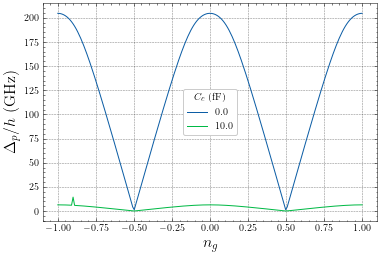

In [19]:
pparam = dict(xlabel='$n_g$', ylabel='$\\Delta_p / h$ (GHz)')

with plt.style.context(['science', 'grid']):
    fig, ax = plt.subplots(figsize=(6,4))
    for Cc in fig17b_data_p.keys():
        ax.plot(fig17b_ngs, [np.abs(np.real(delta * 1e-9)) / h for delta in fig17b_data_p[Cc]], label=round(Cc * 1e15, 1))
    ax.legend(title='$C_c$ (fF)')
    ax.set(**pparam)
    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)
    fig.savefig('figures/Direct Coupling/delta_p wrt Cc ng.png', dpi=300)
    plt.show()

## Figure 17c

In [20]:
system = SparseSystem(ncut=5, Cc=6.76e-15, Cjp=4.767e-16, Cjt=1.683e-14, Ct=1.705e-14, Ejp=2.86e+11, Ejt=4.851e+10, alpha=0.2829)
fig17c_ngs = np.linspace(-1, 1, 200)
fig_17c_Ccs = [val * 1e-15 for val in range(1, 9)]
fig_17c_Ccs = [fig_17c_Ccs[0], fig_17c_Ccs[3], fig_17c_Ccs[-1]]
fig17c_data = {}

system._print_params()

for Cc in fig_17c_Ccs:
    system.Cc = Cc
    fig17c_data[Cc] = {
        'g_parr': [],
        'g_perp': [],
        'delta_p': [],
        'delta_t': []
    }
    for ng in tqdm(fig17c_ngs):
        system.ng = ng

        # Full Hamiltonina Approach
        g_parr = system.calc_g_parr(update=True)
        fig17c_data[Cc]['g_parr'].append(g_parr)

        # Full Hamiltonina Approach
        g_perp = system.calc_g_perp()
        fig17c_data[Cc]['g_perp'].append(g_perp)

        # Full Hamiltonina Approach
        delta_p = system.calc_delta_p()
        fig17c_data[Cc]['delta_p'].append(delta_p)

        # Full Hamiltonina Approach
        delta_t = system.calc_delta_t()
        fig17c_data[Cc]['delta_t'].append(delta_t)

Ejp:    286.0 GHz
Ejt:    48.51 GHz
Cjp:    0.4767 fF
Cjt:    16.83 fF
Ct:    17.05 fF
Cc:    6.76 fF
alpha: 0.2829
ng:    0.12
flux:  0.5


  0%|                                                   | 0/200 [00:00<?, ?it/s]/home/daniel/.local/lib/python3.8/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
100%|█████████████████████████████████████████| 200/200 [01:30<00:00,  2.22it/s]


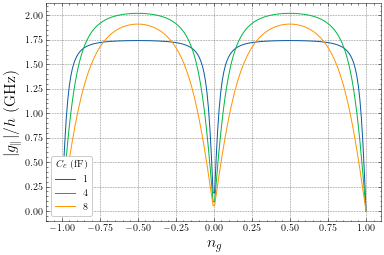

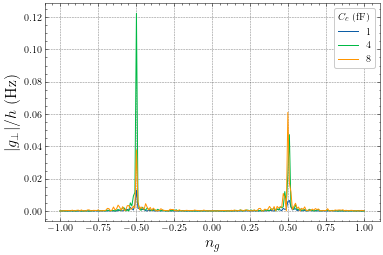

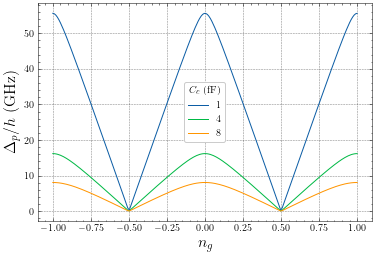

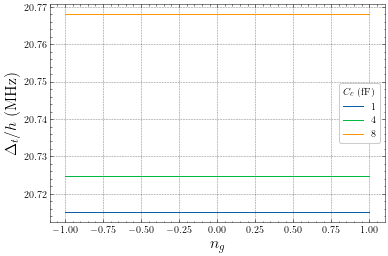

In [21]:
pparam = dict(xlabel='$n_g$', ylabel='$| g_\parallel | / h$ (GHz)')

with plt.style.context(['science', 'grid']):
    fig, ax = plt.subplots(figsize=(6,4))
    for Cc in fig17c_data.keys():
        ax.plot(fig17c_ngs, [np.abs(g_parr * 1e-9) / h for g_parr in fig17c_data[Cc]['g_parr']], label=round(Cc * 1e15))
    ax.legend(title='$C_c$ (fF)')
    ax.set(**pparam)
    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)
    fig.savefig('figures/Direct Coupling/g_parr wrt Cc ng.png', dpi=300)
    plt.show()

pparam = dict(xlabel='$n_g$', ylabel='$| g_\perp | / h$ (Hz)')

with plt.style.context(['science', 'grid']):
    fig, ax = plt.subplots(figsize=(6,4))
    for Cc in fig17c_data.keys():
        ax.plot(fig17c_ngs, [np.abs(g_perp) / h for g_perp in fig17c_data[Cc]['g_perp']], label=round(Cc * 1e15))
    ax.legend(title='$C_c$ (fF)')
    ax.set(**pparam)
    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)
    fig.savefig('figures/Direct Coupling/g_perp wrt Cc ng optimal.png', dpi=300)
    plt.show()

pparam = dict(xlabel='$n_g$', ylabel='$\\Delta_p / h$ (GHz)')

with plt.style.context(['science', 'grid']):
    fig, ax = plt.subplots(figsize=(6,4))
    for Cc in fig17c_data.keys():
        ax.plot(fig17c_ngs, [np.abs(g_perp) * 1e-9 / h for g_perp in fig17c_data[Cc]['delta_p']], label=round(Cc * 1e15))
    ax.legend(title='$C_c$ (fF)')
    ax.set(**pparam)
    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)
    fig.savefig('figures/Direct Coupling/delta_p wrt Cc ng optimal.png', dpi=300)
    plt.show()

pparam = dict(xlabel='$n_g$', ylabel='$\\Delta_t / h$ (MHz)')

with plt.style.context(['science', 'grid']):
    fig, ax = plt.subplots(figsize=(6,4))
    for Cc in fig17c_data.keys():
        ax.plot(fig17c_ngs, [np.abs(g_perp) * 1e-9 / h for g_perp in fig17c_data[Cc]['delta_t']], label=round(Cc * 1e15))
    ax.legend(title='$C_c$ (fF)')
    ax.set(**pparam)
    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)
    fig.savefig('figures/Direct Coupling/delta_t wrt Cc ng optimal.png', dpi=300)
    plt.show()

## Figure 17d

In [22]:
fig_17d_Ccs = np.linspace(0, 10e-15, 100)

system = SparseSystem(ncut=4, Cc=6.76e-15, Cjp=4.767e-16, Cjt=1.683e-14, Ct=1.705e-14, Ejp=2.86e+11, Ejt=4.851e+10, alpha=0.2829)

system._print_params()

fig17d_data = []

for Cc in tqdm(fig_17d_Ccs):
    system.Cc = Cc

    # Full Hamiltonina Approach
    g_parr = system.calc_g_parr(update=True)
    fig17d_data.append(g_parr)

Ejp:    286.0 GHz
Ejt:    48.51 GHz
Cjp:    0.4767 fF
Cjt:    16.83 fF
Ct:    17.05 fF
Cc:    6.76 fF
alpha: 0.2829
ng:    0.12
flux:  0.5


  0%|                                                   | 0/100 [00:00<?, ?it/s]/home/daniel/.local/lib/python3.8/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
100%|█████████████████████████████████████████| 100/100 [00:35<00:00,  2.78it/s]


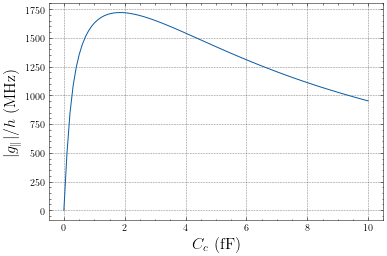

In [23]:
pparam = dict(xlabel='$C_c$ (fF)', ylabel='$| g_\parallel | / h$ (MHz)')

with plt.style.context(['science', 'grid']):
    fig, ax = plt.subplots(figsize=(6,4))
    ax.plot([val * 1e15 for val in fig_17d_Ccs], [np.abs(g_parr) * 1e-6 / h for g_parr in fig17d_data])
    ax.set(**pparam)
    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)
    fig.savefig('figures/Direct Coupling/g_parr wrt Cc.png', dpi=300)
    plt.show()

# Adjusting Probe-Target Detuning

## Probe Qubit Tuning

### Varying $E_{Jp}$

In [24]:
fig_pt_detuning_Ejp = np.linspace(0, 400e9, 100)
fig_pt_detuning_Ejp_delta_p = []
fig_pt_detuning_Ejp_g_parr = []

sys = SparseSystem(ncut=5, Cc=6.76e-15, Cjp=4.767e-16, Cjt=1.683e-14, Ct=1.705e-14, Ejp=2.86e+11, Ejt=4.851e+10, alpha=0.2829, ng=0.3235)

system._print_params()

for Ejp in tqdm(fig_pt_detuning_Ejp):
    sys.Ejp = Ejp * h
    
    delta_p = sys.calc_delta_p(update=True)
    fig_pt_detuning_Ejp_delta_p.append(delta_p)
    
    g_parr = sys.calc_g_parr()
    fig_pt_detuning_Ejp_g_parr.append(g_parr)

Ejp:    286.0 GHz
Ejt:    48.51 GHz
Cjp:    0.4767 fF
Cjt:    16.83 fF
Ct:    17.05 fF
Cc:    10.0 fF
alpha: 0.2829
ng:    0.12
flux:  0.5


  0%|                                                   | 0/100 [00:00<?, ?it/s]/home/daniel/.local/lib/python3.8/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
100%|█████████████████████████████████████████| 100/100 [00:55<00:00,  1.81it/s]


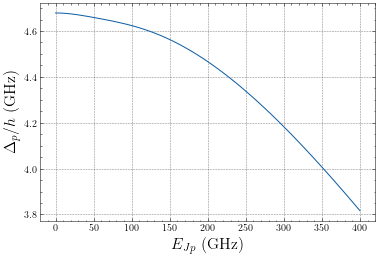

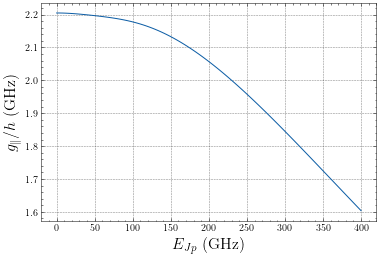

In [25]:
pparam = dict(xlabel='$E_{Jp}$ (GHz)', ylabel='$\\Delta_p / h$ (GHz)')

with plt.style.context(['science', 'grid']):
    fig, ax = plt.subplots(figsize=(6,4))
    ax.plot([val * 1e-9 for val in fig_pt_detuning_Ejp], [np.abs(delta_p) * 1e-9 / h for delta_p in fig_pt_detuning_Ejp_delta_p])
    ax.set(**pparam)
    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)
    fig.savefig('figures/Direct Coupling/delta_p wrt Ejp.png', dpi=300)
    plt.show()

pparam = dict(xlabel='$E_{Jp}$ (GHz)', ylabel='$g_\\parallel / h$ (GHz)')

with plt.style.context(['science', 'grid']):
    fig, ax = plt.subplots(figsize=(6,4))
    ax.plot([val * 1e-9 for val in fig_pt_detuning_Ejp], [np.abs(g_parr) * 1e-9 / h for g_parr in fig_pt_detuning_Ejp_g_parr])
    ax.set(**pparam)
    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)
    fig.savefig('figures/Direct Coupling/g_parr wrt Ejp.png', dpi=300)
    plt.show()

### Varying $C_{Jp}$

In [26]:
fig_pt_detuning_Cjp = np.linspace(1e-15, 1e-13, 100)
fig_pt_detuning_Cjp_g_parr = []
fig_pt_detuning_Cjp_g_perp = []
fig_pt_detuning_Cjp_delta_p = []

sys = SparseSystem(ncut=5, Cc=6.76e-15, Cjp=4.767e-16, Cjt=1.683e-14, Ct=1.705e-14, Ejp=2.86e+11, Ejt=4.851e+10, alpha=0.2829, ng=0.3235)

sys._print_params()

for Cjp in tqdm(fig_pt_detuning_Cjp):
    sys.Cjp = Cjp

    g_parr = sys.calc_g_parr(update=True)
    fig_pt_detuning_Cjp_g_parr.append(g_parr)
    
    g_perp = sys.calc_g_perp()
    fig_pt_detuning_Cjp_g_perp.append(g_perp)
    
    delta_p = sys.calc_delta_p()
    fig_pt_detuning_Cjp_delta_p.append(delta_p)

Ejp:    286.0 GHz
Ejt:    48.51 GHz
Cjp:    0.4767 fF
Cjt:    16.83 fF
Ct:    17.05 fF
Cc:    6.76 fF
alpha: 0.2829
ng:    0.3235
flux:  0.5


  0%|                                                   | 0/100 [00:00<?, ?it/s]/home/daniel/.local/lib/python3.8/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
100%|█████████████████████████████████████████| 100/100 [00:45<00:00,  2.20it/s]


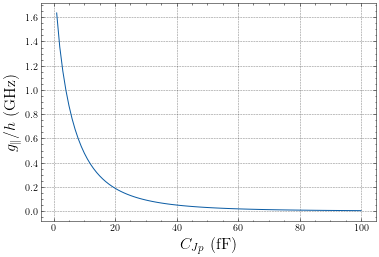

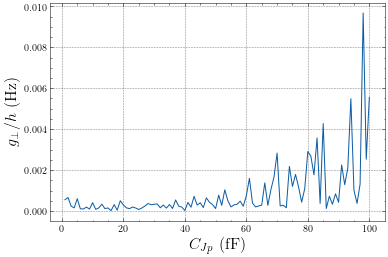

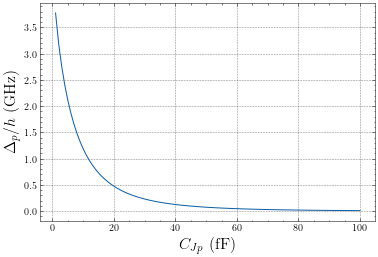

In [27]:
pparam = dict(xlabel='$C_{Jp}$ (fF)', ylabel='$g_\\parallel / h$ (GHz)')

with plt.style.context(['science', 'grid']):
    fig, ax = plt.subplots(figsize=(6,4))
    ax.plot([val * 1e15 for val in fig_pt_detuning_Cjp], [np.abs(g_parr) * 1e-9 / h for g_parr in fig_pt_detuning_Cjp_g_parr])
    ax.set(**pparam)
    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)
    fig.savefig('figures/Direct Coupling/g_parr wrt Cjp.png', dpi=300)
    plt.show()
    
pparam = dict(xlabel='$C_{Jp}$ (fF)', ylabel='$g_\\perp / h$ (Hz)')

with plt.style.context(['science', 'grid']):
    fig, ax = plt.subplots(figsize=(6,4))
    ax.plot([val * 1e15 for val in fig_pt_detuning_Cjp], [np.abs(g_perp) / h for g_perp in fig_pt_detuning_Cjp_g_perp])
    ax.set(**pparam)
    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)
    fig.savefig('figures/Direct Coupling/g_perp wrt Cjp.png', dpi=300)
    plt.show()

pparam = dict(xlabel='$C_{Jp}$ (fF)', ylabel='$\\Delta_p / h$ (GHz)')

with plt.style.context(['science', 'grid']):
    fig, ax = plt.subplots(figsize=(6,4))
    ax.plot([val * 1e15 for val in fig_pt_detuning_Cjp], [np.abs(delta_p) * 1e-9 / h for delta_p in fig_pt_detuning_Cjp_delta_p])
    ax.set(**pparam)
    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)
    fig.savefig('figures/Direct Coupling/Delta_t wrt Cjp.png', dpi=300)
    plt.show()

## Target Qubit Tuning

### Varying $E_{Jt}$

In [28]:
# fig_pt_detuning_Ejt = np.linspace(8.5e9, 27e9, 20)
fig_pt_detuning_Ejt = np.linspace(0, 200e9, 100)
fig_pt_detuning_Ejt_g_parr = []
fig_pt_detuning_Ejt_delta_t = []
fig_pt_detuning_Ejt_delta_t_bare = []
fig_pt_detuning_Ejt_delta_p = []

# sys = SparseSystem(ncut=5, ng=0.25, alpha=0.135, Ejp=115e9, Ct=120e-15)
sys = SparseSystem(ncut=4, Cc=6.76e-15, Cjp=4.767e-16, Cjt=1.683e-14, Ct=1.705e-14, Ejp=2.86e+11, Ejt=4.851e+10, alpha=0.2829, ng=0.3235)

sys._print_params()

for Ejt in tqdm(fig_pt_detuning_Ejt):
    sys.Ejt = Ejt * h

    # Full Hamiltonina Approach
    g_parr = sys.calc_g_parr(update=True)
    fig_pt_detuning_Ejt_g_parr.append(g_parr)
    
    delta_t = sys.calc_delta_t()
    fig_pt_detuning_Ejt_delta_t.append(delta_t)
    
    evals_t, evecs_t = sys.diagonalise_t()
    fig_pt_detuning_Ejt_delta_t_bare.append(evals_t[1] - evals_t[0])
    
    delta_p = sys.calc_delta_p()
    fig_pt_detuning_Ejt_delta_p.append(delta_p)

Ejp:    286.0 GHz
Ejt:    48.51 GHz
Cjp:    0.4767 fF
Cjt:    16.83 fF
Ct:    17.05 fF
Cc:    6.76 fF
alpha: 0.2829
ng:    0.3235
flux:  0.5


  0%|                                                   | 0/100 [00:00<?, ?it/s]/home/daniel/.local/lib/python3.8/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
100%|█████████████████████████████████████████| 100/100 [00:37<00:00,  2.68it/s]


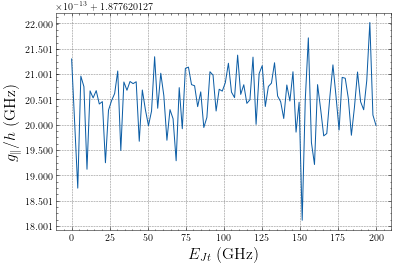

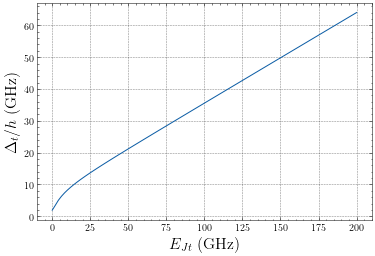

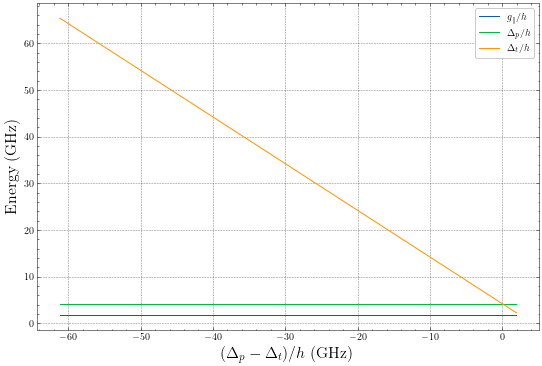

In [29]:
pparam = dict(xlabel='$E_{Jt}$ (GHz)', ylabel='$g_\\parallel / h$ (GHz)')

with plt.style.context(['science', 'grid']):
    fig, ax = plt.subplots(figsize=(6,4))
    ax.plot([val * 1e-9 for val in fig_pt_detuning_Ejt], [np.abs(g_parr) * 1e-9 / h for g_parr in fig_pt_detuning_Ejt_g_parr])
    ax.set(**pparam)
    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)
    fig.savefig('figures/Direct Coupling/g_parr wrt Ejt.png', dpi=300)
    plt.show()

pparam = dict(xlabel='$E_{Jt}$ (GHz)', ylabel='$\\Delta_t / h$ (GHz)')

with plt.style.context(['science', 'grid']):
    fig, ax = plt.subplots(figsize=(6,4))
    # ax.plot([val * 1e-9 for val in fig_pt_detuning_Ejt], [np.abs(delta_t) * 1e-9 / h for delta_t in fig_pt_detuning_Ejt_delta_t])
    ax.plot([val * 1e-9 for val in fig_pt_detuning_Ejt], [np.abs(delta_t) * 1e-9 / h for delta_t in fig_pt_detuning_Ejt_delta_t_bare])
    ax.set(**pparam)
    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)
    fig.savefig('figures/Direct Coupling/Delta_t wrt Ejt.png', dpi=300)
    plt.show()

pparam = dict(xlabel='$(\\Delta_p - \\Delta_t) / h$ (GHz)', ylabel='Energy (GHz)')

with plt.style.context(['science', 'grid']):
    fig, ax = plt.subplots(figsize=(9,6))
    ax.plot([(np.abs(fig_pt_detuning_Ejt_delta_p[idx]) - np.abs(fig_pt_detuning_Ejt_delta_t[idx])) * 1e-9 / h for idx in range(len(fig_pt_detuning_Ejt))], [np.abs(g_parr) * 1e-9 / h for g_parr in fig_pt_detuning_Ejt_g_parr], label='$g_\parallel / h$')
    ax.plot([(np.abs(fig_pt_detuning_Ejt_delta_p[idx]) - np.abs(fig_pt_detuning_Ejt_delta_t[idx])) * 1e-9 / h for idx in range(len(fig_pt_detuning_Ejt))], [np.abs(delta_p) * 1e-9 / h for delta_p in fig_pt_detuning_Ejt_delta_p], label='$\Delta_p / h$')
    ax.plot([(np.abs(fig_pt_detuning_Ejt_delta_p[idx]) - np.abs(fig_pt_detuning_Ejt_delta_t[idx])) * 1e-9 / h for idx in range(len(fig_pt_detuning_Ejt))], [np.abs(delta_t) * 1e-9 / h for delta_t in fig_pt_detuning_Ejt_delta_t], label='$\Delta_t / h$')
    ax.set(**pparam)
    plt.legend()
    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)
    fig.savefig('figures/Direct Coupling/g_parr wrt detuning.png', dpi=300)
    plt.show()

### Varying $C_{Jt}$

In [30]:
fig_pt_detuning_Cjt = np.linspace(1e-15, 1e-13, 100)
fig_pt_detuning_Cjt_g_parr = []
fig_pt_detuning_Cjt_g_perp = []
fig_pt_detuning_Cjt_delta_t = []
fig_pt_detuning_Cjt_delta_t_bare = []

sys = SparseSystem(ncut=5, Cc=6.76e-15, Cjp=4.767e-16, Cjt=1.683e-14, Ct=1.705e-14, Ejp=2.86e+11, Ejt=4.851e+10, alpha=0.2829, ng=0.3235)

sys._print_params()

for Cjt in tqdm(fig_pt_detuning_Cjt):
    sys.Cjt = Cjt

    g_parr = sys.calc_g_parr(update=True)
    fig_pt_detuning_Cjt_g_parr.append(g_parr)
    
    g_perp = sys.calc_g_perp()
    fig_pt_detuning_Cjt_g_perp.append(g_perp)
    
    delta_t = sys.calc_delta_t()
    fig_pt_detuning_Cjt_delta_t.append(delta_t)

Ejp:    286.0 GHz
Ejt:    48.51 GHz
Cjp:    0.4767 fF
Cjt:    16.83 fF
Ct:    17.05 fF
Cc:    6.76 fF
alpha: 0.2829
ng:    0.3235
flux:  0.5


  0%|                                                   | 0/100 [00:00<?, ?it/s]/home/daniel/.local/lib/python3.8/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
100%|█████████████████████████████████████████| 100/100 [00:45<00:00,  2.20it/s]


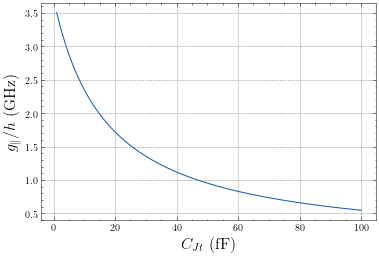

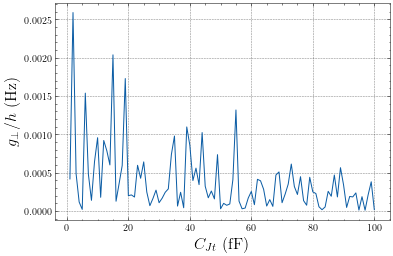

In [32]:
pparam = dict(xlabel='$C_{Jt}$ (fF)', ylabel='$g_\\parallel / h$ (GHz)')

with plt.style.context(['science', 'grid']):
    fig, ax = plt.subplots(figsize=(6,4))
    ax.plot([val * 1e15 for val in fig_pt_detuning_Cjt], [np.abs(g_parr) * 1e-9 / h for g_parr in fig_pt_detuning_Cjt_g_parr])
    ax.set(**pparam)
    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)
    fig.savefig('figures/Direct Coupling/g_parr wrt Cjt.png', dpi=300)
    plt.show()
    
pparam = dict(xlabel='$C_{Jt}$ (fF)', ylabel='$g_\\perp / h$ (Hz)')

with plt.style.context(['science', 'grid']):
    fig, ax = plt.subplots(figsize=(6,4))
    ax.plot([val * 1e15 for val in fig_pt_detuning_Cjt], [np.abs(g_perp) / h for g_perp in fig_pt_detuning_Cjt_g_perp])
    ax.set(**pparam)
    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)
    fig.savefig('figures/Direct Coupling/g_perp wrt Cjt.png', dpi=300)
    plt.show()

pparam = dict(xlabel='$C_{Jt}$ (fF)', ylabel='$\\Delta_t / h$ (GHz)')

### Varying $C_{t}$

In [33]:
fig_pt_detuning_Ct = np.linspace(1e-15, 1e-13, 100)
fig_pt_detuning_Ct_g_parr = []
fig_pt_detuning_Ct_g_perp = []
fig_pt_detuning_Ct_delta_t = []

sys = SparseSystem(ncut=5, Cc=6.76e-15, Cjp=4.767e-16, Cjt=1.683e-14, Ct=1.705e-14, Ejp=2.86e+11, Ejt=4.851e+10, alpha=0.2829, ng=0.3235)

system._print_params()

for Ct in tqdm(fig_pt_detuning_Ct):
    sys.Ct = Ct

    g_parr = sys.calc_g_parr(update=True)
    fig_pt_detuning_Ct_g_parr.append(g_parr)
    
    g_perp = sys.calc_g_perp()
    fig_pt_detuning_Ct_g_perp.append(g_perp)
    
    delta_t = sys.calc_delta_t()
    fig_pt_detuning_Ct_delta_t.append(delta_t)

Ejp:    286.0 GHz
Ejt:    48.51 GHz
Cjp:    0.4767 fF
Cjt:    16.83 fF
Ct:    17.05 fF
Cc:    10.0 fF
alpha: 0.2829
ng:    0.12
flux:  0.5


  0%|                                                   | 0/100 [00:00<?, ?it/s]/home/daniel/.local/lib/python3.8/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
100%|█████████████████████████████████████████| 100/100 [01:01<00:00,  1.64it/s]


In [34]:
def safe_div(num, denom):
    if denom == 0:
        return 0
    else:
        return num / denom

fig_pt_detuning_Ct_delta_t_theory = []
for Ct in fig_pt_detuning_Ct:
    Ect = safe_div(e_charge**2, 2 * (sys.Cjt + Ct))
    omega = np.sqrt((sys.Ejt * h)**2 + (4 * Ect)**2)
    fig_pt_detuning_Ct_delta_t_theory.append(omega)

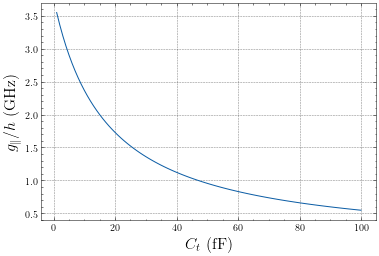

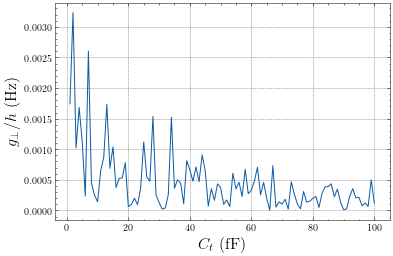

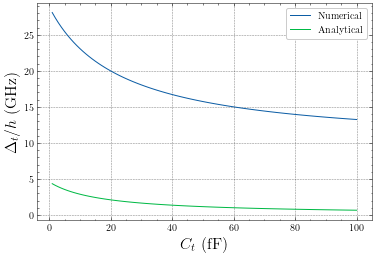

In [35]:
pparam = dict(xlabel='$C_t$ (fF)', ylabel='$g_\\parallel / h$ (GHz)')

with plt.style.context(['science', 'grid']):
    fig, ax = plt.subplots(figsize=(6,4))
    ax.plot([val * 1e15 for val in fig_pt_detuning_Ct], [np.abs(g_parr) * 1e-9 / h for g_parr in fig_pt_detuning_Ct_g_parr])
    ax.set(**pparam)
    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)
    fig.savefig('figures/Direct Coupling/g_parr wrt Ct.png', dpi=300)
    plt.show()
    
pparam = dict(xlabel='$C_t$ (fF)', ylabel='$g_\\perp / h$ (Hz)')

with plt.style.context(['science', 'grid']):
    fig, ax = plt.subplots(figsize=(6,4))
    ax.plot([val * 1e15 for val in fig_pt_detuning_Ct], [np.abs(g_perp) / h for g_perp in fig_pt_detuning_Ct_g_perp])
    ax.set(**pparam)
    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)
    fig.savefig('figures/Direct Coupling/g_perp wrt Ct.png', dpi=300)
    plt.show()

pparam = dict(xlabel='$C_t$ (fF)', ylabel='$\\Delta_t / h$ (GHz)')

with plt.style.context(['science', 'grid']):
    fig, ax = plt.subplots(figsize=(6,4))
    ax.plot([val * 1e15 for val in fig_pt_detuning_Ct], [np.abs(delta_t) * 1e-9 / h for delta_t in fig_pt_detuning_Ct_delta_t], label='Numerical')
    ax.plot([val * 1e15 for val in fig_pt_detuning_Ct], [np.abs(delta_t_bare) * 1e-9 / h for delta_t_bare in fig_pt_detuning_Ct_delta_t_theory], label='Analytical')
    ax.set(**pparam)
    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)
    plt.legend()
    fig.savefig('figures/Direct Coupling/Delta_t wrt Ct.png', dpi=300)
    plt.show()

## Bayesian Optimisation of Parameters

In [ ]:
def cost_func(Cc, Ct, Cjt, Cjp, Ejp, Ejt, alpha, ng):
    sys = SparseSystem(
        ncut=4,
        Cc=Cc,
        Ct=Ct,
        Cjt=Cjt,
        Cjp=Cjp,
        Ejp=Ejp,
        Ejt=Ejt,
        alpha=alpha,
        ng=ng
    )
    
    Ect = e_charge**2 / (2 * (Cc + Ct + Cjt))
    
    delta_p = np.abs(sys.calc_delta_p(update=True)) * 1e-9 / h
    delta_t = np.abs(sys.calc_delta_t()) * 1e-9 / h
    g_parr = np.abs(sys.calc_g_parr()) * 1e-6 / h
    g_perp = np.abs(sys.calc_g_perp()) / h
    Ejt_Ect_ratio = (Ejt * h) / Ect
    
    cost = -(0.5 * (delta_p - 6))**2  # Bias to 4-8 GHz
    cost += -(0.5 * (delta_t - 6))**2  # Bias to 4-8 GHz
    cost += -(0.02 * (g_parr - 2000))**2  # Bias to 100-300 MHz
    cost += -(0.1 * (Ejt_Ect_ratio - 75))**2  # Bias to 50-100
    
    return cost

In [ ]:
import warnings
warnings.filterwarnings("ignore")

from bayes_opt import BayesianOptimization
from bayes_opt.logger import JSONLogger, ScreenLogger
from bayes_opt.event import Events
from bayes_opt.util import load_logs

pbounds = {
    'Cc': (1e-15, 1e-14),
    'Ct': (1e-15, 5e-13),
    'Cjt': (1e-15, 5e-14),
    'Cjp': (1e-16, 5e-14),
    'Ejp': (100e9, 500e9),
    'Ejt': (20e9, 100e9),
    'alpha': (0.1, 0.4),
    'ng': (0.1, 0.4)
}

optimizer = BayesianOptimization(
    f=cost_func,
    pbounds=pbounds,
    random_state=40,
)

# load_logs(optimizer, logs=["./bayesian_opt/logs.json"]);

# logger = JSONLogger(path="./bayesian_opt/logs.json")
logger = ScreenLogger(verbose=1)
logger._default_cell_size = 10
optimizer.subscribe(Events.OPTIMIZATION_START, logger)
optimizer.subscribe(Events.OPTIMIZATION_STEP, logger)
 
# print("New optimizer is now aware of {} points.".format(len(optimizer.space)))

optimizer.maximize(
    init_points=1,
    n_iter=1,
    acq="ei"
)

In [ ]:
print(optimizer.max)

sys = SparseSystem(
    ncut=4,
    Cc=optimizer.max['params']['Cc'],
    Ct=optimizer.max['params']['Ct'],
    Cjt=optimizer.max['params']['Cjt'],
    Cjp=optimizer.max['params']['Cjp'],
    Ejp=optimizer.max['params']['Ejp'],
    Ejt=optimizer.max['params']['Ejt'],
    alpha=optimizer.max['params']['alpha'],
    ng=optimizer.max['params']['ng']
)

Ect = e_charge**2 / (2 * (optimizer.max['params']['Cc'] + optimizer.max['params']['Ct'] + optimizer.max['params']['Cjt']))

delta_p = np.abs(sys.calc_delta_p(update=True)) * 1e-9 / h
delta_t = np.abs(sys.calc_delta_t()) * 1e-9 / h
g_parr = np.abs(sys.calc_g_parr()) * 1e-6 / h
g_perp = np.abs(sys.calc_g_perp()) / h
Ejt_Ect_ratio = (optimizer.max['params']['Ejt'] * h) / Ect

print(f'Delta_p: {delta_p}')
print(f'Delta_t: {delta_t}')
print(f'g parr: {g_parr}')
print(f'g perp: {g_perp}')
print(f'EJt / ECt: {Ejt_Ect_ratio}')

In [ ]:
{'target': -8.042047630047167, 'params': {'Cc': 3.129142972517251e-15, 'Cjp': 1.2247067811373906e-14, 'Cjt': 3.63545372858879e-14, 'Ct': 1.8458674453847166e-14, 'Ejp': 153689038737.95462, 'Ejt': 21316376304.9163, 'alpha': 0.25098471383921855, 'ng': 0.12330261658015346}}

## Lifetimes

In [15]:
diff_param = 0.01
ng0 = 0.5

sys = SparseSystem(ncut=3)
sys.calc_D(ng0=0.5, diff_param=0.01)

print(sys.omega_01)
print(sys.D_z)
print(sys.D_omega01)
print(sys.D2_z)
print(sys.D_perp)

1.3671728883468028e-22
9807856095.846966
(-94937608824.999-0.0020863094903899784j)
2.9604153626830696e+43
13870403108.554176


In [14]:
Amp_ng_noise = 1e-4
omega_low = 2 * np.pi
t_exp = 10e-6

T_phi = Amp_ng_noise * sys.D_omega01  * np.sqrt(2 * np.abs(np.log(omega_low) * t_exp))
print(T_phi)

(57558.77151188625-5.904292346252165e-10j)


### Simulate $1/f$ Time Series

In [ ]:
dt = 1e-4
N = 100001
NF = int((N + 1) / 2)
DF = 1 / (N * dt)
Amp = 1
psd_f = np.linspace(0, NF * DF, NF)
x0 = 0

f_ir = 0.1
k_ir = np.argmin(abs(psd_f - f_ir))
f_uv = 10
k_uv = np.argmin(abs(psd_f - f_uv))
psd_f[psd_f < f_ir] = 0
psd_f[psd_f > f_uv] = 0

data = np.insert(2**-0.5 * (np.random.rand(NF - 1) + 1j * np.random.rand(NF - 1)), 0, x0)

psd = np.append(np.zeros(k_ir), np.append((Amp / np.linspace(0, NF * DF, NF))[k_ir:k_uv], np.zeros(NF - k_uv)))

amp_filter = np.sqrt(np.append(psd, np.flip(psd)) * DF * 0.5)
data_f = np.append(data, np.conjugate(np.flip(data)))

data_f *= amp_filter

x = np.real(np.fft.ifft(data_f))

In [ ]:
plt.plot([val * dt for val in range(len(x))], x)
plt.show()

### Master Equation Solver

In [ ]:
import qutip as qt

In [ ]:
sys = SparseSystem(ncut=2, ng=0.5)
sys.init_qubit_states()

H_p = qt.Qobj(sys.get_H_p())

ket_0 = qt.Qobj(sys.probe_0_eb)
ket_1 = qt.Qobj(sys.probe_1_eb)

sigmax = ket_0 * ket_1.dag() + ket_1 * ket_0.dag()
sigmay = 1j * (ket_0 * ket_1.dag() - ket_1 * ket_0.dag())
sigmaz = ket_1 * ket_1.dag() - ket_0 * ket_0.dag()

H_00 = H_p.matrix_element(ket_0.dag(), ket_0)
H_01 = H_p.matrix_element(ket_0.dag(), ket_1)
H_10 = H_p.matrix_element(ket_1.dag(), ket_0)
H_11 = H_p.matrix_element(ket_1.dag(), ket_1)

H = qt.Qobj([[H_00, H_01], [H_10, H_11]])

psi0 = ket_1

sys = SparseSystem(ncut=2, ng=0.6)
H_pert = qt.Qobj(sys.get_H_p())

result = qt.mesolve(H_pert, 2**-0.5 * (ket_0 + ket_1), np.linspace(0, 0.1, 3), [sigmax, sigmay, sigmaz])

# for time_step in range(10):
#     times = [0, ]
#     result = qt.mesolve(H_p, ket_1, times, [H_pert], [sigmax, sigmay, sigmaz])

In [ ]:
fig, ax = plt.subplots()
ax.plot(times, sys.mod_squared(result.expect[0]))
ax.plot(times, sys.mod_squared(result.expect[1]))
ax.plot(times, sys.mod_squared(result.expect[2]))
ax.set_xlabel('Time') 
ax.set_ylabel('Expectation values') 
ax.legend(("Sigma-X", "Sigma-Y", "Sigma-Z"))  
plt.show() 

In [ ]:
sys = SparseSystem(ncut=3, ng=1e10)
print(sys.get_H_p())

In [ ]:
sys = SparseSystem(ncut=3, ng=5)
print(sys.get_H_p())

## Probe Anharmonicity

In [ ]:
angarmonicity_ngs = np.linspace(-1, 1, 200)
E0s, E1s, E2s, E3s  = [], [], [], []
anhamonicities = []

sys = SparseSystem(ncut=5)

for ng in tqdm(angarmonicity_ngs):
    sys.ng = ng
    evals, evecs = sys.diagonalise_p(update=True)
    
    evals = np.sort(evals)
    
    E0s.append(evals[0])
    E1s.append(evals[1])
    E2s.append(evals[2])
    E3s.append(evals[3])
    
    anhamonicities.append((evals[1] - evals[0]) - (evals[2] - evals[1]))

In [ ]:
plt.plot(angarmonicity_ngs, E0s)
plt.plot(angarmonicity_ngs, E1s)
plt.plot(angarmonicity_ngs, E2s)
plt.plot(angarmonicity_ngs, E3s)
plt.show()

plt.plot(angarmonicity_ngs, [val * 1e-9 / h for val in anhamonicities])
plt.show()

In [ ]:
pparam = dict(xlabel='$n_g$', ylabel='Energy (GHz)')

with plt.style.context(['science', 'grid']):
    fig, ax = plt.subplots(figsize=(6,4))
    ax.plot(angarmonicity_ngs, [val * 1e-9 / h for val in E0s], label='$E_0$')
    ax.plot(angarmonicity_ngs, [val * 1e-9 / h for val in E1s], label='$E_1$')
    ax.plot(angarmonicity_ngs, [val * 1e-9 / h for val in E2s], label='$E_2$')
    ax.plot(angarmonicity_ngs, [val * 1e-9 / h for val in E3s], label='$E_3$')
    ax.set(**pparam)
    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)
    plt.legend()
    fig.savefig('figures/General/probe sprectrum wrt ng.png', dpi=300)
    plt.show()

pparam = dict(xlabel='$n_g$', ylabel='$\Delta_{01} - \Delta_{12}$ (GHz)')

with plt.style.context(['science', 'grid']):
    fig, ax = plt.subplots(figsize=(6,4))
    ax.plot(angarmonicity_ngs, [val * 1e-9 / h for val in anhamonicities])
    ax.set(**pparam)
    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)
    fig.savefig('figures/General/anharmonicity wrt ng.png', dpi=300)
    plt.show()